# ID3决策树

决策树的一个重要任务是为了<span style="border-bottom:2px dashed red"><font color=blue size=2 face="黑体">数据中所蕴含的知识信息</font></span>，因此决策树可以使用不熟悉的数据集合，并从中提取出一系列规则，在这些机器根据数据创建规则时，就是机器学习的过程。专家系统中经常使用决策树

## 决策树的构造

|决策树|
|:-|:-|
|优点|计算复杂度不高，输出结果易于理解，对中间值的缺失不敏感，可以处理不相关特征数据|
|缺点|可能会产生过度匹配问题|
|适用数据类型|数值型和标称型|

使用**信息论**划分数据集  
第一个**问题**就是，**当前数据集上哪个特征在划分数据分类时起决定性作用**。为了找到**决定性的特征**，划分出最好的结果，我们必须**评估每个特征 ** 

创建分支的伪代码函数createBranch()  
    1检测数据集中的每个子项是否属于同一分类：  
    2　　If so return 类标签；  
    3　　Else  
    4　　　寻找划分数据集的最好特征  
    5　　　划分数据集  
    6　　　创建分支节点  
    7　　　　for 每个划分的子集  
    8　　　　　调用函数createBranch并增加返回结果到分支节点中  
    9　　　　return 分支节点

|决策树的一般流程|
|:-|:-|
|收集数据|可以使用任何方法|
|准备数据|树构造算法只适用于标称型数据,因此数值型数据必须离散化|
|分析数据|可以使用任何方法，构造树完成之后，我们应该检查图形是否符合预期|
|训练算法|构造树的数据结构|
|测试算法|使用经验树计算错误率|
|使用算法|此步骤可以适用于任何监督学习算法，而使用决策树可以更好地理解数据的内在含义|

### 信息增益

划分数据集的大原则是：将无序的数据变得更加有序。  
组织杂乱无章数据的一种方法就是使用信息论度量信息，信息论是量化处理信息的分支科学。  
在划分数据集之前之后信息发生的变化称为信息增益，获得信息增益最高的特征就是最好的选择。  
熵定义为信息的期望值，明晰这个概念前，要知道信息的定义  
$$l(x_{i})=log_{2}p(x_{i})$$  
$p(x_{i})$是选择该分类的概率计算熵，需计算所有类别所有值包含的信息期望  
$$H=-\sum_{i=1}^{n}log_{2}p(x_{i})$$

In [42]:
from math import log

# 计算给定数据集的香农熵


def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    # 为所有可能类创建字典
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0
    # 计算香农熵，以2为底求对数
    for key in labelCounts:
        prob = labelCounts[key]/numEntries
        shannonEnt -= prob*log(prob, 2)
    return shannonEnt

In [43]:
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    # change to discrete values
    return dataSet, labels

In [44]:
myDat, labels = createDataSet()
myDat
calcShannonEnt(myDat)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

0.9709505944546686

熵越高,则混合的数据也越多,我们可以在数据集中添加更多的分类,观察熵是如何变化

In [39]:
myDat[0][-1] = 'maybe'
myDat
calcShannonEnt(myDat)

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

1.3709505944546687

得到熵之后,我们就可以按照获取最大信息增益的方法划分数据集.  
另一个度量集合无序程度的方法是**基尼不纯度（Gini impurity）**，简单地说就是从一个数据集中随机选取子项，度量其被错误分类到其他分组里的概率。

### 划分数据集

In [40]:
# 按照给定特征划分数据集
def splitDataSet(dataSet, axis, value):
    # 创建新的list对象
    retDataSet = []
    for featVec in dataSet:
        # 抽取符合特征的数据
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]  # chop out axis used for splitting
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

三个输入参数：**待划分的数据集、划分数据集的特征、需要返回的特征的值**。需要注意的是，Python语言不用考虑内存分配问题。Python语言在函数中传递的是列表的引用，在函数内部对列表对象的修改，将会影响该列表对象的整个生存周期。为了消除这个不良影响，我们需要在函数的开始声明一个新列表对象。  
Python语言list类型自带的**extend()和append()**方法。这两个方法功能类似，但是在处理多个列表时，这两个方法的处理结果是完全不同的。

接下来我们将遍历整个数据集，循环计算香农熵和splitDataSet()函数，找到最好的特征划分方式。熵计算将会告诉我们如何划分数据集是最好的数据组织方式。

In [38]:
# 选择最好的数据集划分方式
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1  # the last column is used for the labels
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):  # iterate over all the features
        # create a list of all the examples of this feature
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)  # get a set of unique values
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        # calculate the info gain; ie reduction in entropy
        infoGain = baseEntropy - newEntropy
        if (infoGain > bestInfoGain):  # compare this to the best gain so far
            bestInfoGain = infoGain  # if better than current best, set to best
            bestFeature = i
    return bestFeature  # returns an integer

该函数实现**选取特征，划分数据集，计算得出最好的划分数据集的特征**。调用的数据需要满足一定的要求：第一个要求是，数据必须是一种由列表元素组成的列表，而且所有的列表元素都要具有相同的数据长度；第二个要求是，数据的最后一列或者每个实例的最后一个元素是当前实例的类别标签。  
集合数据类型与列表类型相似，不同之处仅在于集合类型中的每个值互不相同。从列表中创建集合是Python语言得到列表中唯一元素值的最快方法。  
**信息增益是熵的减少或者是数据无序度的减少**，将熵用于度量数据无序度的减少更容易理解。

In [37]:
chooseBestFeatureToSplit(myDat)

0

### 递归构建决策树

**工作原理如下**：得到原始数据集，然后基于最好的属性值划分数据集，由于特征值可能多于两个，因此可能存在大于两个分支的数据集划分。第一次划分之后，数据将被向下传递到树分支的下一个节点，在这个节点上，我们可以再次划分数据。因此我们可以采用递归的原则处理数据集。  
**递归结束的条件是**：程序遍历完所有划分数据集的属性，或者每个分支下的所有实例都具有相同的分类。也可以设置算法可以划分的最大分组数目。
其他决策树算法，如C4.5和CART，这些算法在运行时并不总是在每次划分分组时都会消耗特征。如果数据集已经处理了所有属性，但是类标签依然不是唯一的，通常会采用多数表决的方法决定该叶子节点的分类。

In [36]:
import operator


def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(),  # operator操作键值排序
                              key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]  # 返回出现次数最多的分类名称

In [6]:
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]  # stop splitting when all of the classes are equal
    if len(dataSet[0]) == 1:  # stop splitting when there are no more features in dataSet
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel: {}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        # copy all of labels, so trees don't mess up existing labels
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(
            splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

输入参数：数据集和标签列表。在每个数据集划分上递归调用函数createTree()，得到的返回值将被插入到字典变量myTree中。循环的第一行subLabels=labels[:]，这行代码复制了类标签，并将其存储在新列表变量subLabels中。因为在Python语言中函数参数是列表类型时，参数是按照引用方式传递的。为了保证每次调用函数createTree()时不改变原始列表的内容，使用新变量subLabels代替原始列表。

In [11]:
myDat, labels = createDataSet()
myTree = createTree(myDat, labels)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 使用Matplotlib注解绘制树形图

决策树的主要优点就是直观易于理解

### Matplotlib注解

Matplotlib提供了一个注解工具annotations

In [45]:
# 使用文本注解绘制树节点
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")


def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,
                            xytext=centerPt,
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)


def createPlot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()  # 情空绘图区
    # 函数属性createPlot.ax1，python通过函数属性实现全局变量
    createPlot.ax1 = plt.subplot(111, frameon=False)  # ticks for demo puropses
    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()


createPlot()

<Figure size 640x480 with 1 Axes>

该函数需要一个绘图区，该区域由全局变量createPlot.ax1定义。Python语言中所有的变量默认都是全局有效的

### 构造注解树

绘制一棵完整的树需要一些技巧。我们虽然有x、y坐标，但是如何放置所有的树节点却是个问题。我们必须知道有多少个叶节点，以便可以正确确定x轴的长度；我们还需要知道树有多少层，以便可以正确确定y轴的高度。这里我们定义两个新函数getNumLeafs()和getTreeDepth()，来获取叶节点的数目和树的层数

In [46]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        # test to see if the nodes are dictonaires, if not they are leaf nodes
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs


def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        # test to see if the nodes are dictonaires, if not they are leaf nodes
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

这里使用的数据结构说明了如何在Python字典类型中存储树信息。type()函数可以判断子节点是否为字典类型。如果子节点是字典类型，则该节点也是一个判断节点。为了节省大家的时间，函数retrieveTree输出预先存储的树信息，避免了每次测试代码时都要从数据中创建树的麻烦。

In [47]:
def retrieveTree(i):
    listOfTrees = [{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                   {'no surfacing': {0: 'no', 1: {'flippers': {
                       0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                   ]
    return listOfTrees[i]

函数createPlot()是我们使用的主函数，它调用了plotTree()，函数plotTree又依次调用了前面介绍的函数和plotMidText()。同时使用两个[全局变量plotTree.xOff和plotTree.yOff](https://www.cnblogs.com/fantasy01/p/4595902.html)追踪已经绘制的节点位置，以及放置下一个节点的恰当位置。通过计算树包含的所有叶子节点数，划分图形的宽度，从而计算得到当前节点的中心位置。如果以像素为单位绘制图形，则缩放图形就不是一件简单的工作。

In [48]:
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center",
                        ha="center", rotation=0)


def plotTree(myTree, parentPt, nodeTxt):  # if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  # this determines the x width of this tree
    depth = getTreeDepth(myTree)
    # the text label for this node should be this
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) /
              2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        # test to see if the nodes are dictonaires, if not they are leaf nodes
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))  # recursion
        else:  # it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff,
                                       plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
# if you do get a dictonary you know it's a tree, and the first element will be another dict


def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)  # no ticks
    # createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

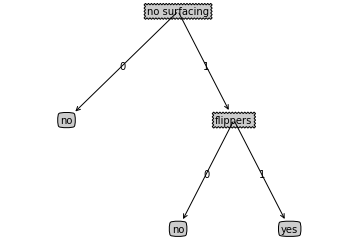

In [49]:
a = retrieveTree(0)
a
createPlot(a)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}, 3: 'maybe'}}

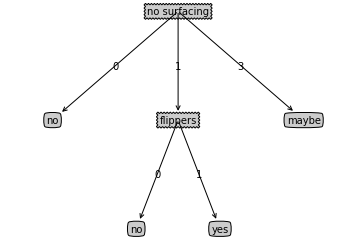

In [50]:
a['no surfacing'][3] = 'maybe'
a
createPlot(a)

## 测试和存储分类器

本节将使用决策树构建分类器，以及实际应用中如何存储分类器

### 测试算法：使用决策树执行分类

依靠训练数据构造了决策树之后，我们可以将它用于实际数据的分类。在执行数据分类时，需要决策树以及用于构造树的标签向量。然后，程序比较测试数据与决策树上的数值，递归执行该过程直到进入叶子节点；最后将测试数据定义为叶子节点所属的类型。

In [51]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict):
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else:
        classLabel = valueOfFeat
    return classLabel

递归函数。在存储带有特征的数据会面临一个问题：程序无法确定特征在数据集中的位置。使用index方法查找当前列表中第一个匹配firstStr变量的元素。然后代码递归遍历整棵树，比较testVec变量中的值与树节点的值，如果到达叶子节点，则返回当前节点的分类标签。

In [15]:
myDat, labels = createDataSet()
myTree
classify(myTree, labels, [1, 0])
classify(myTree, labels, [1, 1])

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

'no'

'yes'

现在我们已经创建了使用决策树的分类器，但是每次使用分类器时，必须重新构造决策树，下一节我们将介绍如何在硬盘上存储决策树分类器。

### 使用算法：决策树的存储

构造决策树是很耗时的任务，即使处理很小的数据集。然而用创建好的决策树解决分类问题，则可以很快完成。为了解决这个问题，需要使用Python模块pickle序列化对象。序列化对象可以在磁盘上保存对象，并在需要的时候读取出来。任何对象都可以执行序列化操作，字典对象也不例外。

In [30]:
def storeTree(inputTree, filename):
    import pickle
    fw = open(filename, 'wb')
    pickle.dump(inputTree, fw)
    fw.close()


def grabTree(filename):
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)

In [31]:
storeTree(myTree, 'classifierStorage.txt')
grabTree('classifierStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

通过上面的代码，可以将分类器存储在硬盘上，而不用每次对数据分类时重新学习一遍，这也是决策树的优点之一，像第二章介绍了k-近邻算法就无法持久化分类器。我们可以预先提炼并存储数据集中包含的知识信息，在需要对事物进行分类时再使用这些知识。

## 示例：使用决策树预测隐形眼镜类型

本节我们将通过一个例子讲解决策树如何预测患者需要佩戴的隐形眼镜类型。

|示例：使用决策树预测隐形眼镜类型|
|:-|:-|
|收集数据|提供的文本文件|
|准备数据|解析tab键分隔的数据行|
|分析数据|快速检查数据，确保正确地解析数据内容，使用createPlot()函数绘制最终的树形图|
|训练算法|使用createTree()函数|
|测试算法|编写测试函数验证决策树可以正确分类给定的数据实例|
|使用算法|存储树的数据结构，以便下次使用时无需重新构造树|

[隐形眼镜数据集](http://archive.ics.uci.edu/ml/machine-learning-databases/lenses/)是非常著名的数据集，它包含很多患者眼部状况的观察条件以及医生推荐的隐形眼镜类型。隐形眼镜类型包括硬材质、软材质以及不适合佩戴隐形眼镜。

{'tearRate': {'reduced': 'no lenses',
  'normal': {'astigmatic': {'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'young': 'hard',
        'presbyopic': 'no lenses'}},
      'myope': 'hard'}},
    'no': {'age': {'pre': 'soft',
      'young': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft',
        'myope': 'no lenses'}}}}}}}}

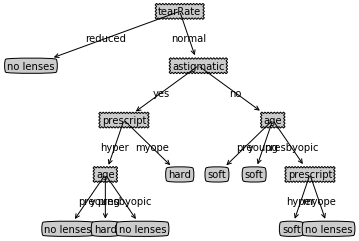

In [53]:
fr = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)
lensesTree
createPlot(lensesTree)
fr.close()

沿着决策树的不同分支，我们可以得到不同患者需要佩戴的隐形眼镜类型。

决策树非常好地匹配了实验数据，然而这些匹配选项可能太多了。我们将这种问题称之为过度匹配(overfitting)。为了减少过度匹配问题，我们可以裁剪决策树，去掉一些不必要的叶子节点。  
ID3算法无法直接处理数值型数据，尽管我们可以通过量化的方法将数值型数据转化为标称型数值，但是如果存在太多的特征划分，ID3算法仍然会面临其他问题。

## 本章小结

决策树分类器就像带有终止块的流程图，终止块表示分类结果。测量数据的不一致性，也就是熵，然后寻找最优方案划分数据集，直到数据集中的所有数据属于同一分类。  
使用Matplotlib的注解功能，我们可以将存储的树结构转化为容易理解的图形。Python语言的pickle模块可用于存储决策树的结构。我们可以通过裁剪决策树，合并相邻的无法产生大量信息增益的叶节点，消除过度匹配问题。  
其他的决策树的构造算法,最流行的是C4.5和CART